# Predicting Survival on Titanic Passenger Data

In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
import sklearn
import seaborn as sns
from patsy import dmatrices

In [2]:
dfTitanicTrain = pd.read_csv('C:/Users/c708682/Downloads/train.csv')
dfTitanicTest = pd.read_csv('C:/Users/c708682/Downloads/test.csv')
dfTitanicFull = pd.concat([dfTitanicTrain, dfTitanicTest])

In [3]:
dfTitanicFull.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
0,22,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0,A/5 21171
1,38,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1,PC 17599
2,26,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1,STON/O2. 3101282
3,35,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1,113803
4,35,NaN,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0,373450


In [4]:
    dfTitanicFull.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 12 columns):
Age            1046 non-null float64
Cabin          295 non-null object
Embarked       1307 non-null object
Fare           1308 non-null float64
Name           1309 non-null object
Parch          1309 non-null int64
PassengerId    1309 non-null int64
Pclass         1309 non-null int64
Sex            1309 non-null object
SibSp          1309 non-null int64
Survived       891 non-null float64
Ticket         1309 non-null object
dtypes: float64(3), int64(4), object(5)
memory usage: 132.9+ KB


## Missing values analysis

In [5]:
dfTitanicFull['Pclass'].isnull().sum()

0

In [6]:
dfTitanicFull['Sex'].isnull().sum()

0

In [7]:
dfTitanicFull['Age'].isnull().sum()

263

In [8]:
dfTitanicFull['SibSp'].isnull().sum()

0

In [9]:
dfTitanicFull['Parch'].isnull().sum()

0

In [10]:
dfTitanicFull['Fare'].isnull().sum()

1

In [11]:
dfTitanicFull['Cabin'].isnull().sum()

1014

In [12]:
dfTitanicFull['Embarked'].isnull().sum()

2

The numeric variable 'Age' has many missing values, which must be replaced. I replace them with the median of the corresponding passenger class group

In [13]:
med = dfTitanicFull.groupby('Pclass')['Age'].transform('median')

In [14]:
dfTitanicFull['Age'] = dfTitanicFull['Age'].fillna(med)

In [15]:
# Test again
dfTitanicFull['Age'].isnull().sum()

0

Replacing Text with Scores in Sex and Embarked:

In [16]:
# transform sex to integer

dfTitanicFull['Sex'].replace('female' , 1, inplace=True)
dfTitanicFull['Sex'].replace('male' , 0, inplace=True)
dfTitanicTrain['Sex'].replace('female' , 1, inplace=True)
dfTitanicTrain['Sex'].replace('male' , 0, inplace=True)

In [17]:
# transform Embarked to integer

dfTitanicFull['Embarked'].replace('S' , 0, inplace=True)
dfTitanicFull['Embarked'].replace('C' , 1, inplace=True)
dfTitanicFull['Embarked'].replace('Q' , 2, inplace=True)

dfTitanicTrain['Embarked'].replace('S' , 0, inplace=True)
dfTitanicTrain['Embarked'].replace('C' , 1, inplace=True)
dfTitanicTrain['Embarked'].replace('Q' , 2, inplace=True)

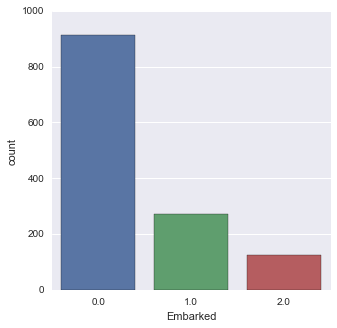

In [18]:
fig, (axis1) = plt.subplots(1,figsize=(5,5))
sns.countplot(x='Embarked', data=dfTitanicFull, ax=axis1)

In [19]:
# replacing the two missing Embarked with 0 because it's the most frequent value
dfTitanicFull['Embarked'] = dfTitanicFull['Embarked'].fillna(0)

,Embarked,Fare
0,0,27.533755
1,1,62.336267
2,2,12.409012


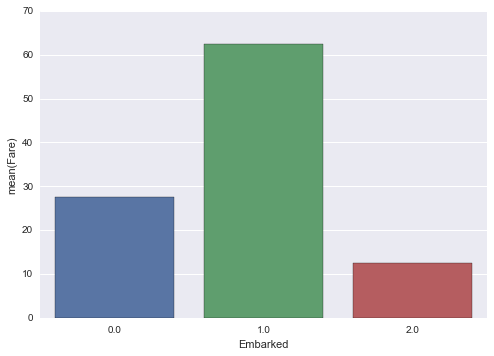

In [20]:
# calc the means of embarkement location

embark_fare = dfTitanicFull[["Embarked", "Fare"]].groupby(['Embarked'], as_index=False).mean()
sns.barplot(x = 'Embarked', y = 'Fare', data=embark_fare)
embark_fare

In [21]:
# Finding and replacing the missing fare with the corresponding mean of the embarkemnt group
dfTitanicFull[dfTitanicFull['Fare'].isnull()]

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
152,60.5,NaN,0,NaN,"Storey, Mr. Thomas",0,1044,3,0,0,NaN,3701


In [22]:
# The numeric variable 'Fare' has two missing values, which must be replaced. I replace it with the median
# of the corresponding Embarked group because fare is most likely dependent on the embarkement place
mean = dfTitanicFull.groupby('Embarked')['Fare'].transform('mean')

dfTitanicFull['Fare'] = dfTitanicFull['Fare'].fillna(mean)
dfTitanicFull[dfTitanicFull['PassengerId'] == 1044 ]

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
152,60.5,NaN,0,27.533755,"Storey, Mr. Thomas",0,1044,3,0,0,NaN,3701


### building new variables:

Family Size could matter for survival, so we can sum up the amount of family members and after differentiate between passengers with no family member aboard at all and others:

In [23]:
dfTitanicFull['FamSize'] = dfTitanicFull['Parch'] + dfTitanicFull['SibSp'] 
dfTitanicFull['FamilyAboard'] = np.where(dfTitanicFull['FamSize'] > 0, 1, 0)

building a child variable

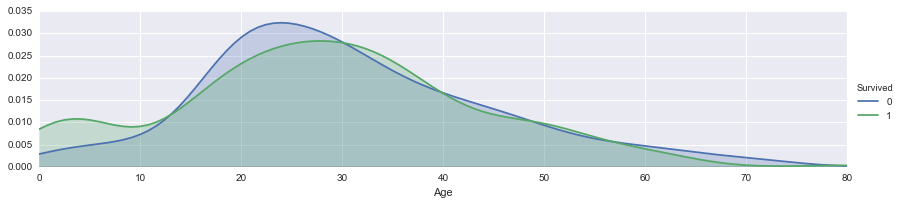

In [24]:
# I'm looking for the age, where survival rate begins to sink
facet = sns.FacetGrid(dfTitanicTrain, hue="Survived",aspect=4)
facet.map(sns.kdeplot,'Age',shade= True)
facet.set(xlim=(0, dfTitanicTrain['Age'].max()))
facet.add_legend()

In [25]:
# The relevant Age for changing the likelyhood of survival lies by Age 14
dfTitanicFull['Child'] = np.where(dfTitanicFull['Age'] < 14, 1, 0)

In [26]:
# split the data in train and test again

dfTitanicTrain = dfTitanicFull[0:890]
dfTitanicTest = dfTitanicFull[891:1309]

Aggregate the child and sex variables:

In [27]:
dfTitanicTrain['Sex'].sum()

314L

In [28]:
dfTitanicTrain['Child'].sum()

71

In [29]:
dfTitanicTrain.groupby(['Child', 'Sex'])['Survived'].mean()



Child  Sex
0      0      0.163265
       1      0.757143
1      0      0.567568
       1      0.617647
Name: Survived, dtype: float64

Aggregate the fare variable:

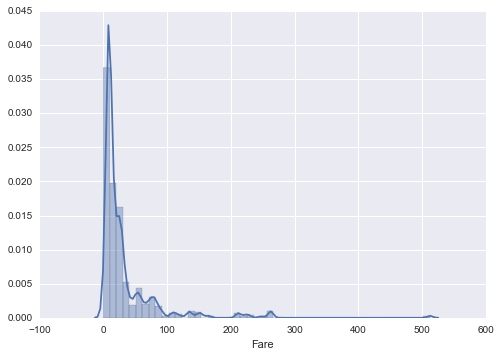

In [30]:
sns.distplot(dfTitanicFull['Fare'])

In [31]:
dfTitanicFull['Faregroup'] =  np.where(dfTitanicFull.Fare<20, 0,
                               np.where(dfTitanicFull.Fare<30, 1,
                               np.where(dfTitanicFull.Fare<40, 2, 3)))

In [32]:
dfTitanicFull.groupby(['Faregroup', 'Pclass', 'Sex'])['Survived'].count()



Faregroup  Pclass  Sex
0          1       0        6
           2       0       69
                   1       35
           3       0      298
                   1      107
1          1       0       30
                   1        6
           2       0       25
                   1       30
           3       0       24
                   1       21
2          1       0       24
                   1        4
           2       0        8
                   1        7
           3       0       10
                   1       11
3          1       0       62
                   1       84
           2       0        6
                   1        4
           3       0       15
                   1        5
Name: Survived, dtype: int64

In [33]:
dfTitanicFull.groupby(['Faregroup', 'Pclass', 'Sex'])['Survived'].mean()

Faregroup  Pclass  Sex
0          1       0      0.000000
           2       0      0.144928
                   1      0.914286
           3       0      0.127517
                   1      0.588785
1          1       0      0.400000
                   1      0.833333
           2       0      0.160000
                   1      0.900000
           3       0      0.125000
                   1      0.333333
2          1       0      0.458333
                   1      1.000000
           2       0      0.375000
                   1      1.000000
           3       0      0.100000
                   1      0.181818
3          1       0      0.354839
                   1      0.976190
           2       0      0.000000
                   1      1.000000
           3       0      0.333333
                   1      0.000000
Name: Survived, dtype: float64

Building a Title variable:

In [34]:
dfTitanicFull['Name'].head()

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
Name: Name, dtype: object

In [35]:
dfTitanicFull['Title'] = dfTitanicFull['Name'].apply(lambda x: x.split(',')[1])
dfTitanicFull['Title'] = dfTitanicFull['Name'].apply(lambda x: x.split(' ')[1])
dfTitanicFull['Title'].value_counts()

Mr.             736
Miss.           256
Mrs.            191
Master.          59
Dr.               8
y                 8
Rev.              8
Col.              4
Planke,           4
Billiard,         3
Impe,             3
Messemaeker,      2
Carlo,            2
Gordon,           2
Mlle.             2
Ms.               2
Major.            2
Capt.             1
Pelsmaeker,       1
Don.              1
Mulder,           1
the               1
Khalil,           1
der               1
Velde,            1
Jonkheer.         1
Walle,            1
Melkebeke,        1
Steen,            1
Palmquist,        1
Mme.              1
Brito,            1
Cruyssen,         1
Shawah,           1
Name: Title, dtype: int64

In [36]:
dfTitanicFull.groupby(['Title'])['Survived'].mean()

Title
Billiard,       0.000000
Brito,               NaN
Capt.           0.000000
Carlo,          0.000000
Col.            0.500000
Cruyssen,       0.000000
Don.            0.000000
Dr.             0.428571
Gordon,         1.000000
Impe,           0.000000
Jonkheer.       0.000000
Khalil,              NaN
Major.          0.500000
Master.         0.575000
Melkebeke,      0.000000
Messemaeker,    1.000000
Miss.           0.703911
Mlle.           1.000000
Mme.            1.000000
Mr.             0.157371
Mrs.            0.801653
Ms.             1.000000
Mulder,         1.000000
Palmquist,           NaN
Pelsmaeker,     0.000000
Planke,         0.000000
Rev.            0.000000
Shawah,         0.000000
Steen,          0.000000
Velde,          0.000000
Walle,          0.000000
der             0.000000
the             1.000000
y               0.750000
Name: Survived, dtype: float64

In [98]:
# split the data in train and test again

dfTitanicTrain = dfTitanicFull[0:890]
dfTitanicTest = dfTitanicFull[891:1309]

## Linear Regression Model


In [99]:
# Linear Regression model with all variables

from sklearn.linear_model import LinearRegression

# Remove non int vars
X_Train = dfTitanicTrain.drop(['Survived', 'PassengerId', 'Name', 'Ticket', 'Cabin', 'Title'], axis = 1)
X_Test = dfTitanicTest.drop(['Survived', 'PassengerId', 'Name', 'Ticket', 'Cabin', 'Title' ], axis = 1)
Y_Train = dfTitanicTrain.Survived

Test again if there are all missing values replaced

In [39]:
X_Test.isnull().any()

Age             False
Embarked        False
Fare            False
Parch           False
Pclass          False
Sex             False
SibSp           False
FamSize         False
FamilyAboard    False
Child           False
Faregroup       False
dtype: bool

In [40]:
X_Train.isnull().any()

Age             False
Embarked        False
Fare            False
Parch           False
Pclass          False
Sex             False
SibSp           False
FamSize         False
FamilyAboard    False
Child           False
Faregroup       False
dtype: bool

linear regression with all variables:

In [41]:
lm = LinearRegression()
lm.fit(X_Train, Y_Train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [42]:
print 'Estimated Intercept Coefficient:', lm.intercept_
print 'Number of coefficients:', len(lm.coef_)
print 'R Square:', lm.score(X_Train, Y_Train)

pd.DataFrame(zip(X_Train.columns, lm.coef_), columns = ['features', 'estimatedCoefficients'])

Estimated Intercept Coefficient: 0.612875383206
Number of coefficients: 11
R Square: 0.413713333383


,features,estimatedCoefficients
0,Age,-0.003633
1,Embarked,0.034062
2,Fare,0.000258
3,Parch,-0.014230
4,Pclass,-0.143456
5,Sex,0.496840
6,SibSp,-0.030673
7,FamSize,-0.044903
8,FamilyAboard,0.087063
9,Child,0.226621


predicting survival with the test data:

In [43]:
# predictors with train data
lm.predict(X_Train)
# using these predictors on the test data  
prediction_Test = lm.predict(X_Test)


building the solution dataframe with two variables, passengerID and survived out of the test data as outcome:

In [44]:
solution = pd.DataFrame({'PassengerId' : dfTitanicTest.PassengerId, 
                         'Survived' : prediction_Test})

In [45]:
solution['Survived'] =  np.where(solution['Survived'] < 0.5, 0,1)


In [46]:
solution.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [47]:
solution.to_csv('C:/Users/c708682/Downloads/submission1.csv', sep=',', header=True, index=False)

# Decision Trees

In [48]:
# Remove  vars
X_Train = dfTitanicTrain.drop(['Survived', 'PassengerId', 'Name', 'Ticket', 'Cabin', 'Title' ], axis = 1)
X_Test = dfTitanicTest.drop(['Survived', 'PassengerId', 'Name', 'Ticket', 'Cabin', 'Title' ], axis = 1)
Y_Train = dfTitanicTrain.Survived

In [49]:
from sklearn import tree

clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_Train, Y_Train)

In [50]:
Tree1_pred = clf.predict(X_Test)

In [51]:
solution = pd.DataFrame({'PassengerId' : dfTitanicTest.PassengerId, 
                         'Survived' : Tree1_pred})

In [52]:
solution.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,1
3,895,1
4,896,0


In [53]:
solution['Survived'] =  np.where(solution['Survived'] < 0.5, 0,1)

In [54]:
solution.to_csv('C:/Users/c708682/Downloads/submission_decTree1.csv', sep=',', header=True, index=False)

# Random Forest

In [83]:
# import the machine learning library that holds the randomforest
import sklearn.ensemble as ske


formula_ml = 'Survived ~ Age + Embarked + Fare + Parch + Pclass + Sex + SibSp + FamSize + FamilyAboard + Child + Faregroup'
# Create the random forest model and fit the model to our training data
y, x = dmatrices(formula_ml, data=dfTitanicTrain, return_type='dataframe')
# RandomForestClassifier expects a 1 demensional NumPy array, so we convert
y = np.asarray(y).ravel()
#instantiate and fit our model
results_rf = ske.RandomForestClassifier(n_estimators=100).fit(x, y)

# Score the results
score = results_rf.score(x, y)
print "Mean accuracy of Random Forest Predictions on the data was: {0}".format(score)

Mean accuracy of Random Forest Predictions on the data was: 0.98202247191


In [108]:
# Here we replace the NaN from Survived in the test data with a float
dfTitanicTest.replace(['Survived'] , [1.2])

#then we build a matrix out of the test data
y, x = dmatrices(formula_ml, data=dfTitanicTest, return_type='dataframe')

#then we predict the y variable Survived with the test data
randTree_pred = results_rf.predict(x)

In [129]:
solution = pd.DataFrame({'PassengerId' : dfTitanicTest.PassengerId, 
                         'Survived' : randTree_pred})
solution['Survived'] =  np.where(solution['Survived'] < 0.5, 0,1)
solution['Survived']

0      0
1      0
2      0
3      1
4      0
5      0
6      0
7      0
8      1
9      0
10     0
11     0
12     1
13     0
14     1
15     1
16     0
17     1
18     0
19     0
20     1
21     1
22     1
23     1
24     1
25     0
26     1
27     1
28     1
29     0
      ..
388    0
389    0
390    0
391    1
392    1
393    0
394    0
395    1
396    0
397    1
398    0
399    0
400    1
401    0
402    1
403    0
404    0
405    0
406    0
407    0
408    1
409    1
410    1
411    1
412    0
413    0
414    1
415    0
416    0
417    0
Name: Survived, dtype: int32

In [134]:
solution = pd.DataFrame({'PassengerId' : dfTitanicTest.PassengerId, 
                         'Survived' : randTree_pred})
solution['Survived'] = solution['Survived'].astype('int')


In [135]:
solution.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,1
4,896,0


In [136]:
solution.to_csv('C:/Users/c708682/Downloads/submission_rdmTree1.csv', sep=',', header=True, index=False)